<a href="https://colab.research.google.com/github/MiladNlpAi/plant-disease-classification-cnn/blob/main/plant_disease_classification_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Import required libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import cv2

In [ ]:
# Install compatible version of DeepLake
!pip install "deeplake<4"

In [3]:
# Load PlantVillage dataset (with augmentation)
import deeplake
ds = deeplake.load('hub://activeloop/plantvillage-with-augmentation')

/usr/local/lib/python3.12/dist-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (4.3.1) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(
/

Opening dataset in read-only mode as you don't have write permissions.


|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/plantvillage-with-augmentation



\

hub://activeloop/plantvillage-with-augmentation loaded successfully.



In [ ]:
# Quick visualization of dataset
ds.visualize()

In [4]:
# Get all available class names
all_classes = ds.labels.info.class_names
print(all_classes)
print("Total classes:", len(all_classes))

['Peach_healthy', 'Strawberry_leaf_scorch', 'Grape_black_measles', 'Tomato_septoria_leaf_spot', 'Grape_healthy', 'Tomato_healthy', 'Peach_bacterial_spot', 'Corn_gray_leaf_spot', 'Soybean_healthy', 'Corn_common_rust', 'Blueberry_healthy', 'Corn_healthy', 'Apple_healthy', 'Apple_cedar_apple_rust', 'Background_without_leaves', 'Tomato_target_spot', 'Pepper_healthy', 'Grape_black_rot', 'Apple_scab', 'Raspberry_healthy', 'Tomato_early_blight', 'Tomato_yellow_leaf_curl_virus', 'Corn_northern_leaf_blight', 'Potato_healthy', 'Tomato_late_blight', 'Cherry_powdery_mildew', 'Grape_leaf_blight', 'Tomato_leaf_mold', 'Pepper_bacterial_spot', 'Potato_late_blight', 'Tomato_mosaic_virus', 'Potato_early_blight', 'Tomato_bacterial_spot', 'Strawberry_healthy', 'Cherry_healthy', 'Squash_powdery_mildew', 'Tomato_spider_mites_two-spotted_spider_mite', 'Orange_haunglongbing', 'Apple_black_rot']
Total classes: 39


In [5]:
# Select a subset of classes (example: corn, grape, cherry)
selected_classes = [
    # Corn
    "Corn_northern_leaf_blight",
    "Corn_gray_leaf_spot",
    "Corn_common_rust",
    "Corn_healthy",
    # Grape
    "Grape_healthy",
    "Grape_black_measles",
    "Grape_black_rot",
    "Grape_leaf_blight",
    # Cherry
    "Cherry_healthy",
    "Cherry_powdery_mildew"
]

In [6]:
# Preprocess dataset: resize images and map labels
x = []
y = []
IMG_SIZE = 128

for i in range(len(ds.labels)):
    label = ds.labels[i].numpy().item()
    class_name = all_classes[label]
    if class_name in selected_classes:
        img = ds.images[i].numpy()
        img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        x.append(img_resized)
        y.append(selected_classes.index(class_name))

print(np.unique(y))

/usr/local/lib/python3.12/dist-packages/deeplake/core/tensor.py:719: UserWarning: Indexing by integer in a for loop, like `for i in range(len(ds)): ... ds.tensor[i]` can be quite slow. Use `for i, sample in enumerate(ds)` instead.
  warnings.warn(


[0 1 2 3 4 5 6 7 8 9]


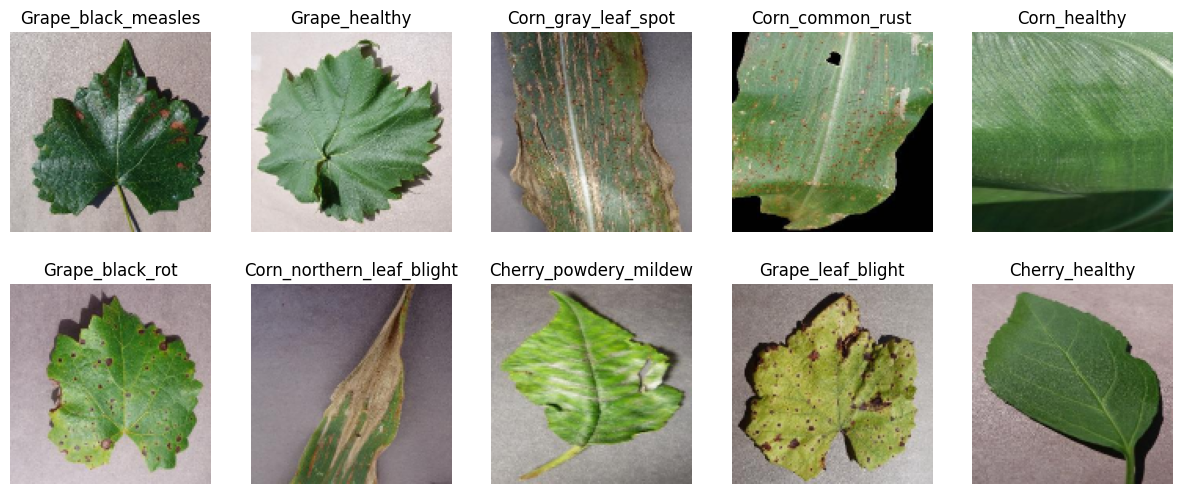

In [7]:
# Show one example image per selected class
unique_images = []
unique_labels = []

for i in range(len(y)):
    label = y[i]
    if label not in unique_labels:
        unique_images.append(x[i])
        unique_labels.append(label)


    if len(unique_labels) == len(selected_classes):
        break


plt.figure(figsize=(15, 6))
for i in range(len(unique_labels)):
    plt.subplot(2, (len(unique_labels)+1)//2, i+1)
    plt.imshow(unique_images[i])
    plt.title(selected_classes[unique_labels[i]])
    plt.axis('off')
plt.show()

In [8]:
# Normalize images

x = np.array(x, dtype='float32') / 255.0
y = np.array(y)

print("Dataset shape:", x.shape, y.shape)
print("Classes:", selected_classes)

Dataset shape: (9656, 128, 128, 3) (9656,)
Classes: ['Corn_northern_leaf_blight', 'Corn_gray_leaf_spot', 'Corn_common_rust', 'Corn_healthy', 'Grape_healthy', 'Grape_black_measles', 'Grape_black_rot', 'Grape_leaf_blight', 'Cherry_healthy', 'Cherry_powdery_mildew']


In [9]:
# Split dataset into train / validation / test
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, stratify=y, random_state=42
)

x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

print("Train:", x_train.shape, "Val:", x_val.shape, "Test:", x_test.shape)

Train: (6179, 128, 128, 3) Val: (1545, 128, 128, 3) Test: (1932, 128, 128, 3)


In [10]:
# Define CNN architecture

model = Sequential([
    Conv2D(input_shape=(128,128,3), filters=32, kernel_size=(3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),

    Dense(10, activation='softmax')
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,913,354 (34.00 MB)

 Trainable params: 8,912,394 (34.00 MB)

 Non-trainable params: 960 (3.75 KB)

In [12]:
# Compile the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [13]:
# Training callbacks
checkpoint = ModelCheckpoint(filepath="PlantVillageFew.h5",
                             monitor="val_accuracy",
                             save_best_only=True,
                             mode="max",
                             verbose=1)

early_stopping = EarlyStopping(monitor="val_accuracy",
                               patience=3,
                               restore_best_weights=True,
                               verbose=1)


history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    callbacks=[checkpoint, early_stopping])

Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.5008 - loss: 3.2117
Epoch 1: val_accuracy improved from -inf to 0.17735, saving model to PlantVillageFew.h5


97/97 ━━━━━━━━━━━━━━━━━━━━ 26s 149ms/step - accuracy: 0.5019 - loss: 3.1999 - val_accuracy: 0.1773 - val_loss: 5.9977
Epoch 2/10
96/97 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7632 - loss: 0.8291
Epoch 2: val_accuracy improved from 0.17735 to 0.18447, saving model to PlantVillageFew.h5


97/97 ━━━━━━━━━━━━━━━━━━━━ 24s 57ms/step - accuracy: 0.7634 - loss: 0.8282 - val_accuracy: 0.1845 - val_loss: 11.2700
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8233 - loss: 0.6054
Epoch 3: val_accuracy did not improve from 0.18447
97/97 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.8235 - loss: 0.6048 - val_accuracy: 0.1094 - val_loss: 18.2872
Epoch 4/10
96/97 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8644 - loss: 0.4291
Epoch 4: val_accuracy improved from 0.18447 to 0.22654, saving model to PlantVillageFew.h5


97/97 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.8647 - loss: 0.4287 - val_accuracy: 0.2265 - val_loss: 6.6524
Epoch 5/10
96/97 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8937 - loss: 0.5120
Epoch 5: val_accuracy improved from 0.22654 to 0.44725, saving model to PlantVillageFew.h5


97/97 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.8941 - loss: 0.5086 - val_accuracy: 0.4472 - val_loss: 4.4819
Epoch 6/10
96/97 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9195 - loss: 0.2737
Epoch 6: val_accuracy improved from 0.44725 to 0.72880, saving model to PlantVillageFew.h5


97/97 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.9195 - loss: 0.2735 - val_accuracy: 0.7288 - val_loss: 0.8656
Epoch 7/10
96/97 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9365 - loss: 0.2238
Epoch 7: val_accuracy improved from 0.72880 to 0.89385, saving model to PlantVillageFew.h5


97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.9365 - loss: 0.2242 - val_accuracy: 0.8939 - val_loss: 0.3444
Epoch 8/10
96/97 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9454 - loss: 0.2011
Epoch 8: val_accuracy did not improve from 0.89385
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.9454 - loss: 0.2013 - val_accuracy: 0.7864 - val_loss: 0.7701
Epoch 9/10
96/97 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9519 - loss: 0.1622
Epoch 9: val_accuracy improved from 0.89385 to 0.94239, saving model to PlantVillageFew.h5


97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.9519 - loss: 0.1623 - val_accuracy: 0.9424 - val_loss: 0.2413
Epoch 10/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9608 - loss: 0.1378
Epoch 10: val_accuracy did not improve from 0.94239
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.9608 - loss: 0.1378 - val_accuracy: 0.9029 - val_loss: 0.5614
Restoring model weights from the end of the best epoch: 9.


In [14]:
# Load the best saved model
best_model = load_model("PlantVillageFew.h5")

In [15]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [16]:
# Evaluate performance
print(history.history['accuracy'])
print(history.history['loss'])
print(history.history['val_accuracy'])
print(history.history['val_loss'])

[0.6140152215957642, 0.7766628861427307, 0.8441495299339294, 0.8760316967964172, 0.9108269810676575, 0.9215083122253418, 0.9338080883026123, 0.9457840919494629, 0.9514484405517578, 0.9605113863945007]
[2.052534341812134, 0.7851229310035706, 0.5455026030540466, 0.41081714630126953, 0.34631258249282837, 0.2638412117958069, 0.24077503383159637, 0.20810912549495697, 0.16737209260463715, 0.1408797651529312]
[0.17734627425670624, 0.18446601927280426, 0.10938511043787003, 0.22653721272945404, 0.4472492039203644, 0.7288025617599487, 0.8938511610031128, 0.7864077687263489, 0.9423947930335999, 0.9029126167297363]
[5.9977498054504395, 11.2699613571167, 18.287246704101562, 6.6524248123168945, 4.481929302215576, 0.865571916103363, 0.34440916776657104, 0.7700733542442322, 0.2412748783826828, 0.5613703727722168]


In [17]:
test_loss, test_acc = best_model.evaluate(x_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")
print(f"Test Accuracy Percent: {test_acc * 100:.2f}%")

61/61 - 7s - 107ms/step - accuracy: 0.9379 - loss: 0.1812
Test Loss: 0.18121479451656342
Test Accuracy: 0.9378882050514221
Test Accuracy Percent: 93.79%


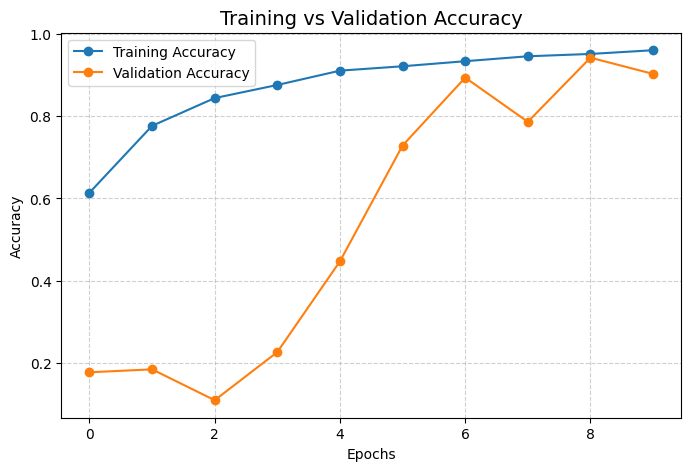

In [18]:
# Training curves
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], marker='o', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], marker='o', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

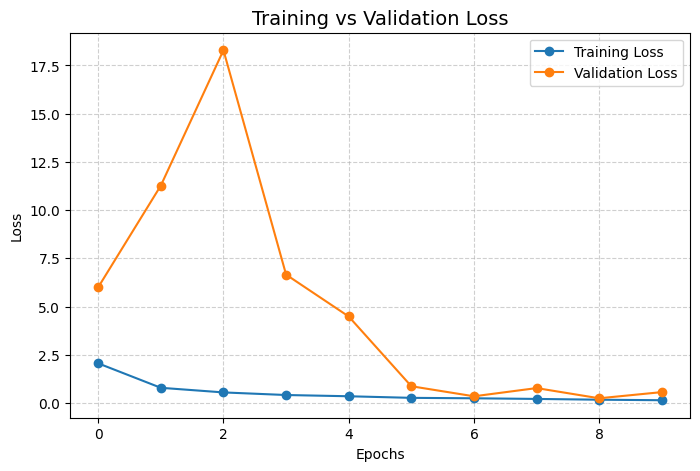

In [19]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], marker='o', label='Training Loss')
plt.plot(history.history['val_loss'], marker='o', label='Validation Loss')
plt.title('Training vs Validation Loss', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

In [44]:
# Single image prediction
from tensorflow.keras.preprocessing import image
image_path = "/content/Grape.png" # replace with your own image
img = image.load_img(image_path, target_size=(128, 128))

In [41]:
img_array = image.img_to_array(img)

img_array = img_array / 255.0

img_array = np.expand_dims(img_array, axis=0)
print(img_array.shape)

(1, 128, 128, 3)


In [42]:
predictions = best_model.predict(img_array)
predicted_class_index = np.argmax(predictions)
print(f"Predicted class index: {predicted_class_index}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted class index: 5


In [43]:
predicted_class_name = selected_classes[predicted_class_index]
print(f"Predicted class: {predicted_class_name}")

Predicted class: Grape_black_measles
